<div align="center">
  <a href="https://blent.ai">
    <img src="https://blent-static-media.s3.eu-west-3.amazonaws.com/images/logo/logo_blent_300x.png" alt="Logo Blent.ai" width="200" />
  </a>
</div>

# Les indispensables du Data Engineer - Hadoop & Spark

In [1]:
import sys

# Permet de savoir si on s'exécute dans Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt-get update -qq > /dev/null && apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget -q https://downloads.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
    !tar xf spark-3.4.0-bin-hadoop3.tgz
    !pip install -q findspark pyspark
    # Cette cellule peut prendre 2 à 3 minutes pour s'exécuter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext

if IN_COLAB:
    import findspark

    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    # Spécifie le chemin où est stocké Spark
    os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

    findspark.init()  # Trouve les exécutables dans le dossier SPARK_HOME

    sc = SparkContext("local")  # Crée un SparkContext local

sql_c = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Spark est maintenant exécuté en local sur Google Colab !

## Récupération des données

In [4]:
!wget https://blent-learning-user-ressources.s3.eu-west-3.amazonaws.com/files/workshop_sql_sample.tar.xz && tar -xf workshop_sql_sample.tar.xz
!rm workshop_sql_sample.tar.xz && mv workshop_sql_sample.csv data.csv

if IN_COLAB:
    !hadoop fs -copyFromLocal data.csv /user/admin/data.csv

--2023-06-22 11:29:26--  https://blent-learning-user-ressources.s3.eu-west-3.amazonaws.com/files/workshop_sql_sample.tar.xz
Resolving blent-learning-user-ressources.s3.eu-west-3.amazonaws.com (blent-learning-user-ressources.s3.eu-west-3.amazonaws.com)... 16.12.20.2
Connecting to blent-learning-user-ressources.s3.eu-west-3.amazonaws.com (blent-learning-user-ressources.s3.eu-west-3.amazonaws.com)|16.12.20.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125605728 (120M) [application/x-www-form-urlencoded]
Saving to: ‘workshop_sql_sample.tar.xz’

workshop_sql_sample 100%[===================>] 119.79M  28.2MB/s    in 4.8s    

2023-06-22 11:29:31 (24.7 MB/s) - ‘workshop_sql_sample.tar.xz’ saved [125605728/125605728]

/bin/bash: hadoop: command not found


In [5]:
data = sql_c.read.csv(
    os.path.expanduser("data.csv") if IN_COLAB else "/user/admin/data.csv",
    header=True
).drop("_c0")
data.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



Par défaut, Spark ne fait aucune conversion implicite des colonnes.

In [6]:
from pyspark.sql import functions as func

data = data \
    .withColumn("event_time", func.col("event_time").cast("timestamp")) \
    .withColumn("product_id", func.col("product_id").cast("int")) \
    .withColumn("price", func.col("price").cast("float")) \
    .withColumn("user_id", func.col("user_id").cast("int"))
data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



Tout comme la fonction `head` avec `pandas`, affichons les premières lignes.

In [7]:
data.show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:04|      view|   1004237|2053013555631882655|electr

Nous pouvons également compter le nombre de lignes.

In [8]:
data.count()

8829315

Essayons de reproduire le code de comptabilisation du nombre d'événements par utilisateur.

In [9]:
count_events = data \
  .groupBy("user_id") \
  .agg(
      func.count("event_type").alias("count")
  )

In [10]:
count_events.show()

+---------+-----+
|  user_id|count|
+---------+-----+
|555447570|    9|
|524493281|    4|
|543091275|    8|
|509481306|    1|
|513992906|    2|
|539234006|    7|
|518093424|    9|
|552509284|   45|
|513431118|   69|
|515959651|    2|
|545114128|    4|
|555464935|    4|
|517597867|   43|
|546839974|   13|
|530039999|    8|
|529847028|    5|
|553649979|    6|
|515687124|   14|
|515772044|    2|
|516400912|    7|
+---------+-----+
only showing top 20 rows



## Comptabiliser le nombre d'achats et de vues par utilisateur

In [11]:
data_sessions = data.filter(func.col("user_session").isNotNull())

events_per_session = data \
  .withColumn(
      "purchased",
      func.when(func.col("event_type") == "purchase", 1).otherwise(0)
  ) \
  .withColumn(
      "num_views",
      func.when(func.col("event_type") == "view", 1).otherwise(0)
  ) \
  .groupBy("user_id") \
  .agg(
      func.sum("purchased").alias("purchased"),
      func.sum("num_views").alias("num_views")
  )

events_per_session.show()

+---------+---------+---------+
|  user_id|purchased|num_views|
+---------+---------+---------+
|555447570|        0|        9|
|524493281|        0|        4|
|543091275|        0|        8|
|509481306|        0|        1|
|513992906|        0|        2|
|539234006|        0|        7|
|518093424|        1|        8|
|552509284|        0|       45|
|513431118|        0|       69|
|515959651|        0|        2|
|545114128|        0|        4|
|555464935|        0|        4|
|517597867|        0|       43|
|546839974|        4|        9|
|530039999|        0|        8|
|529847028|        0|        5|
|553649979|        0|        6|
|515687124|        0|       14|
|515772044|        0|        2|
|516400912|        0|        7|
+---------+---------+---------+
only showing top 20 rows



## Fréquence des événements

Calculer le nombre d'événéments survenus à chaque heure.

In [12]:
data_freq = data \
  .withColumn("hour", func.hour("event_time")) \
  .groupBy("hour") \
  .count() \
  .toPandas()

In [13]:
data_freq.head()

,hour,count
0,12,447321
1,1,108448
2,13,479914
3,6,468183
4,16,650924


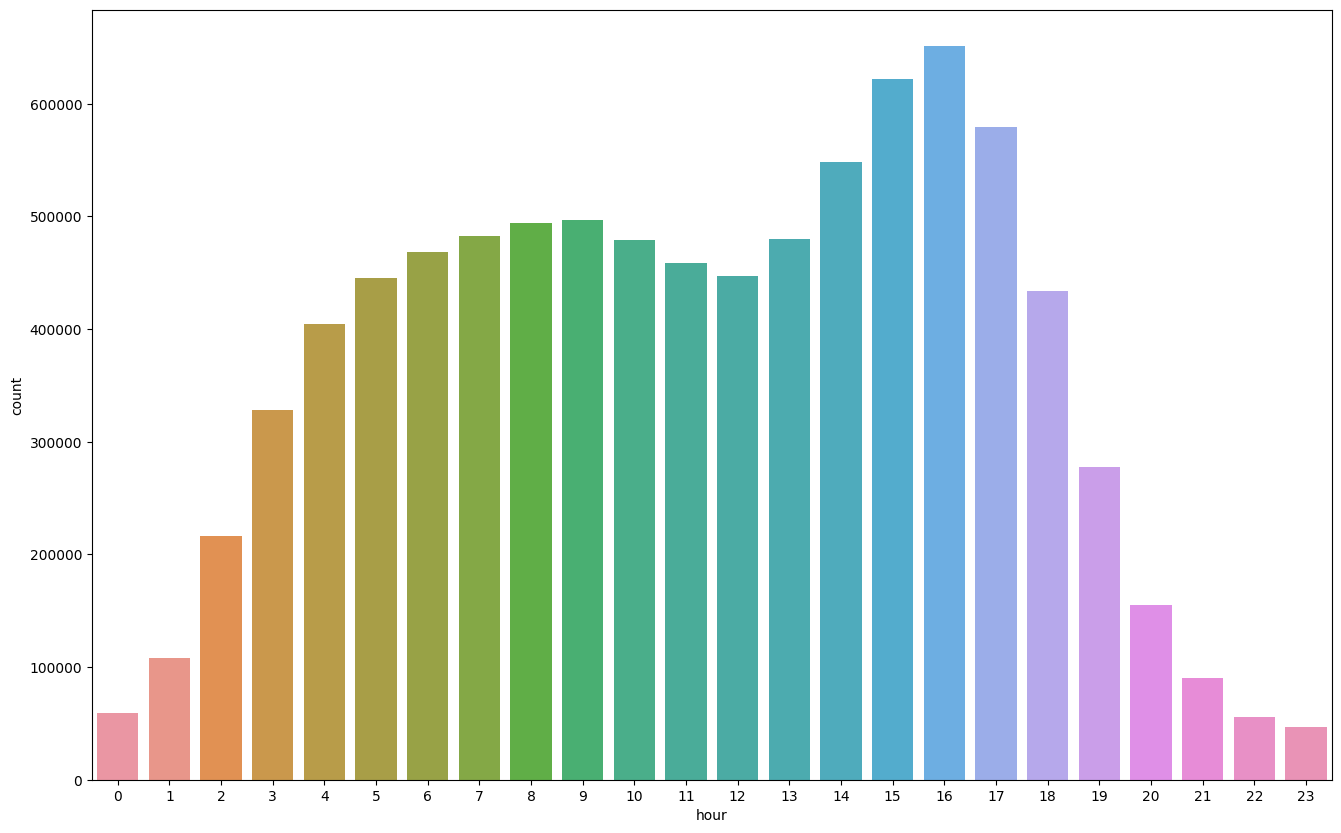

In [14]:
plt.figure(figsize=(16, 10))
sns.barplot(x="hour", y="count", data=data_freq)
plt.show()

## Durée des sessions

Calculer la durée de chaque session.

In [15]:
# On calcule la date minimum et maximum de chaque session
sessions_duration = data_sessions \
    .groupBy("user_session") \
    .agg(
        func.max("event_time").alias("max"),
        func.min("event_time").alias("min")
    ) \
    .withColumn(
        "duration",
        func.col("max").cast("int") - func.col("min").cast("int")
    ) \
    .toPandas()
sessions_duration.head(n=10)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,user_session,max,min,duration
0,c3012f56-70f3-4198-960d-5f14467c0a53,2019-10-01 00:03:35,2019-10-01 00:03:35,0
1,2af9b570-0942-4dcd-8f25-4d84fba82553,2019-10-01 00:09:54,2019-10-01 00:06:31,203
2,78c0b329-af93-44fa-966d-08d7c69a37b1,2019-10-01 00:13:26,2019-10-01 00:13:26,0
3,c7e588c7-78a9-4033-9326-562f7ad76eda,2019-10-01 02:18:59,2019-10-01 02:18:49,10
4,a6b41834-75dd-4cd5-ace6-cbe1a4fe54df,2019-10-01 02:24:02,2019-10-01 02:23:02,60
5,898ff23f-fc70-4239-879d-4ef9226cd6db,2019-10-01 02:30:26,2019-10-01 02:23:46,400
6,85881243-7b33-4098-8418-a2fc9a3c2e05,2019-10-01 02:25:47,2019-10-01 02:24:02,105
7,b36c1441-930a-4a6f-8222-b59d1faf3554,2019-10-01 02:24:22,2019-10-01 02:24:22,0
8,fa1df743-4ef7-4273-b3e3-50a6c7c6671c,2019-10-01 03:20:31,2019-10-01 02:25:56,3275
9,ce054142-5e1d-4ed7-9c99-5ef5627b424a,2019-10-01 02:28:32,2019-10-01 02:27:56,36


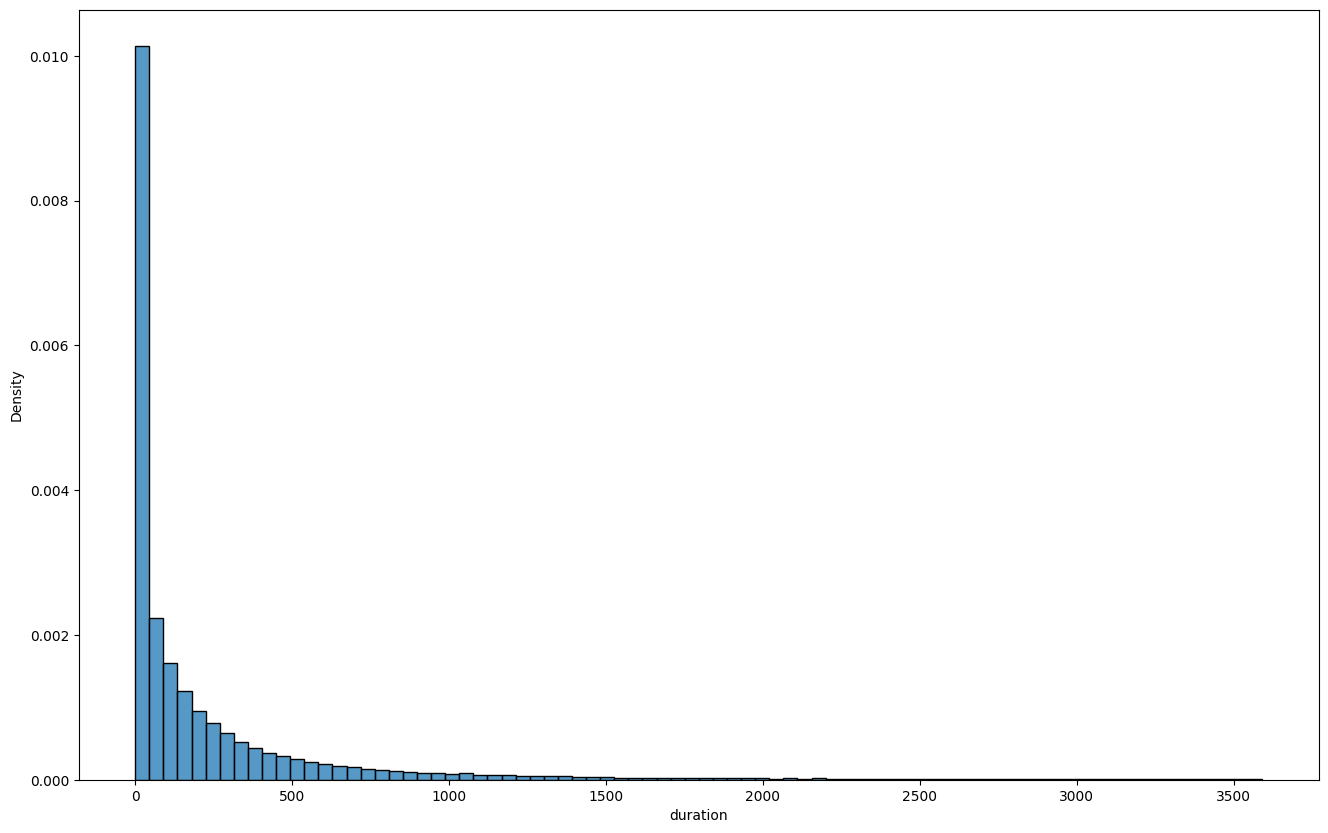

In [16]:
sessions_duration_sample = sessions_duration.loc[sessions_duration["duration"] < 3600, "duration"].sample(100000)

plt.figure(figsize=(16, 10))
sns.histplot(sessions_duration_sample, stat="density", bins=80)
plt.show()

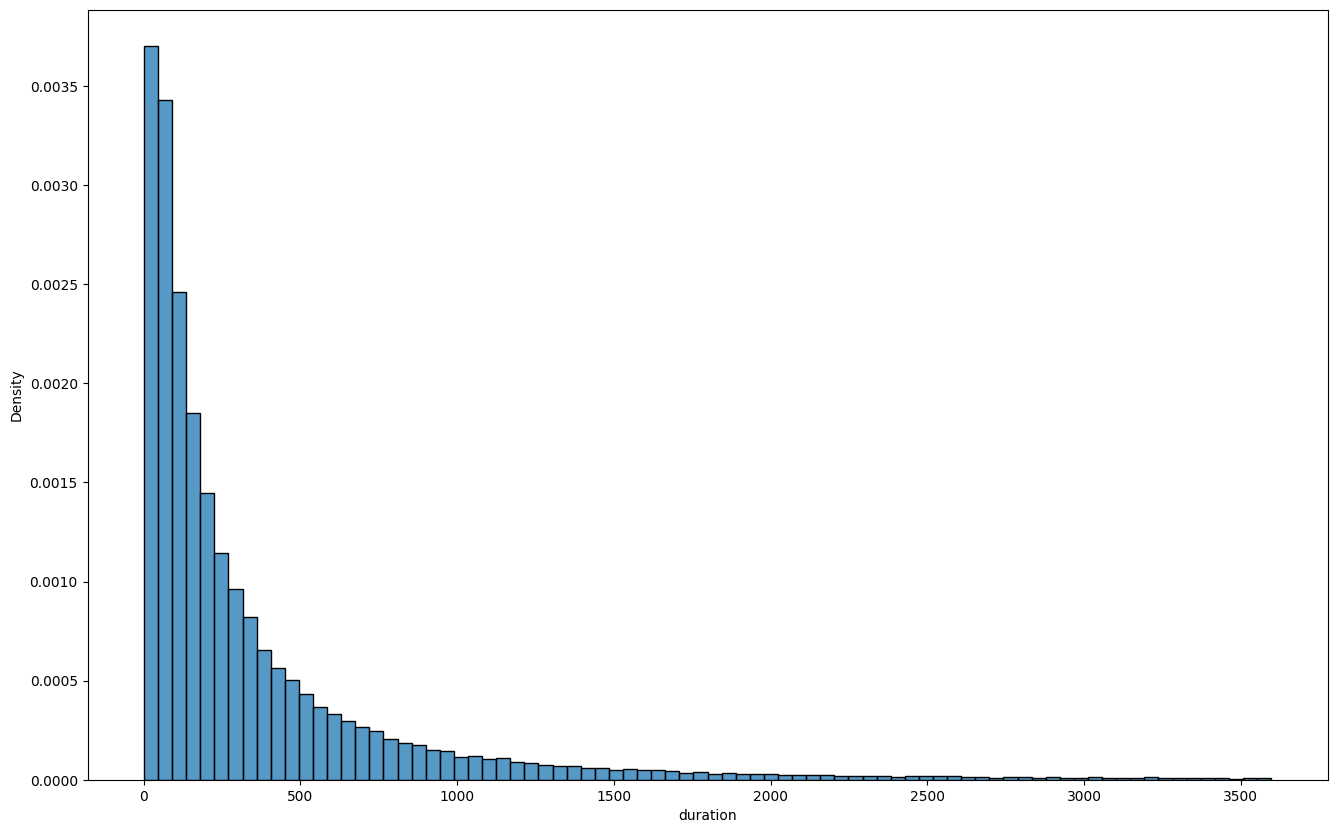

In [17]:
sessions_duration_sample = sessions_duration.loc[
  (sessions_duration["duration"] > 0) & (sessions_duration["duration"] < 3600),
  "duration"] \
  .sample(100000)

plt.figure(figsize=(16, 10))
sns.histplot(sessions_duration_sample, stat="density", bins=80)
plt.show()